In [1]:
import numpy as np
import pandas as pd
import os
import umap
from itertools import chain
import numpy as np
import seaborn as sns
import torch
import seaborn as sns
import matplotlib.pyplot as plt

from umap import UMAP
from torch.nn.functional import normalize
from sklearn.preprocessing import MinMaxScaler

In [2]:
umap.__version__

'0.5.5'

In [12]:
input_dim= 1005
data_path = '/n/data1/hms/dbmi/zitnik/lab/users/was966/ITRP/TCGA-ITRP-GENESET-MERGE/%s/' % input_dim
df_tpm = pd.read_pickle(os.path.join(data_path, 'TPM.TCGA.TABLE'))
df_tpm = np.log2(df_tpm + 1).T

dim = 32
metric = 'correlation'
random_state = 123

# 1. gene2vector

In [8]:
type =  'gene2vect'

url = 'https://raw.githubusercontent.com/jingcheng-du/Gene2vec/master/pre_trained_emb/gene2vec_dim_200_iter_9.txt'
df = pd.read_csv(url, sep='\t', header=None, index_col=0)
df = df[1].apply(lambda x:x.split(' ')).apply(pd.Series)
df = df[df.columns[:-1]]
df.index.name = 'gene_name'
df = df.astype(float)

mp = UMAP(metric = metric, n_components = dim, random_state = random_state)
X = mp.fit_transform(df)
dfd = pd.DataFrame(X, index=df.index )

cg = list(set(df.index) & set(df_tpm.index))
sg = list(set(df_tpm.index) - set(df.index))

/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [10]:
dfpe = dfd.loc[cg]
dfpe = dfpe._append(pd.DataFrame(index=sg)).fillna(0)
dfpe = dfpe.loc[df_tpm.index]

In [13]:
## sort by dim
dfpe = dfpe[dfpe.mean().sort_values().index]
#dfpe.columns = range(len(dfpe.columns))
x_emb = torch.tensor(dfpe.values,dtype=torch.float32)#.requires_grad_(False) 
x_emb = normalize(x_emb, dim=0, p = 2)

torch.save(x_emb, './%s_%s_%s.pt' % (type, input_dim, dim))

Text(0.5, 1.0, 'g2v-correlation-cosine')

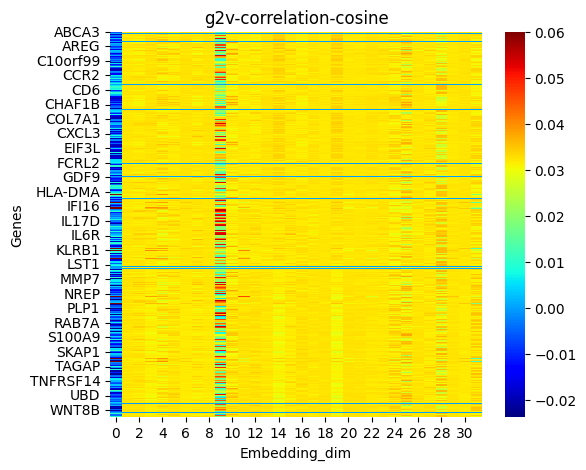

In [14]:
X = x_emb.cpu().numpy()
dfx = pd.DataFrame(X, index = dfpe.index)
fig, ax = plt.subplots(figsize=(6,5))
sns.heatmap(dfx, cmap = 'jet', ax=ax, vmax = 0.06)
ax.set_ylabel('Genes')
ax.set_xlabel('Embedding_dim')
ax.set_title('g2v-%s-%s' % (metric, output_metric))

# 02.UMAP

In [15]:
mp = UMAP(n_components = dim, metric = metric, random_state = random_state, verbose=1)
mp = mp.fit(df_tpm)
x_pos = mp.transform(df_tpm)
dfpe = pd.DataFrame(x_pos, index = df_tpm.index)
dfpe = dfpe[dfpe.mean().sort_values().index]
dfpe.columns = range(len(dfpe.columns))

/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP(angular_rp_forest=True, metric='correlation', n_components=32, random_state=123, verbose=1)
Thu Jan 11 10:42:38 2024 Construct fuzzy simplicial set
Thu Jan 11 10:42:52 2024 Finding Nearest Neighbors
Thu Jan 11 10:42:54 2024 Finished Nearest Neighbor Search
Thu Jan 11 10:42:54 2024 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Thu Jan 11 10:42:58 2024 Finished embedding


In [16]:
type = 'umap'
x_emb = torch.tensor(dfpe.values, dtype=torch.float32)#.requires_grad_(False) 
x_emb = normalize(x_emb, dim=0, p = 2)
torch.save(x_emb, './%s_%s_%s.pt' % (type, input_dim, dim))

Text(0.5, 1.0, 'UMAP-correlation-cosine')

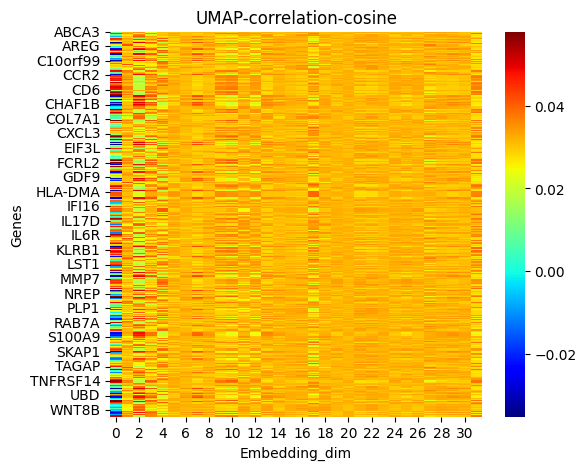

In [17]:
X = x_emb.cpu().numpy()
dfx = pd.DataFrame(X, index = dfpe.index)

fig, ax = plt.subplots(figsize=(6,5))
sns.heatmap(dfx, cmap = 'jet', ax=ax)

ax.set_ylabel('Genes')
ax.set_xlabel('Embedding_dim')
ax.set_title('UMAP-%s-%s' % (metric, output_metric))

# 03.ParametricUMAP

In [19]:
type = 'pumap'

from umap import ParametricUMAP
mp = ParametricUMAP(n_components = dim, 
                    metric = metric, 
                    verbose = 1,
                    random_state = random_state)

data = df_tpm.values
mp.fit(data)
x_pos = mp.transform(data)

dfpe = pd.DataFrame(x_pos, index = df_tpm.index)
dfpe = dfpe[dfpe.mean().sort_values().index]
dfpe.columns = range(len(dfpe.columns))

In [31]:
x_emb = torch.tensor(dfpe.values, dtype=torch.float32)#.requires_grad_(False) 
x_emb = normalize(x_emb, dim=0, p = 2)
torch.save(x_emb, './%s_%s_%s.pt' % (type, input_dim, dim))

Text(0.5, 1.0, 'ParametricUMAP-cosine-euclidean')

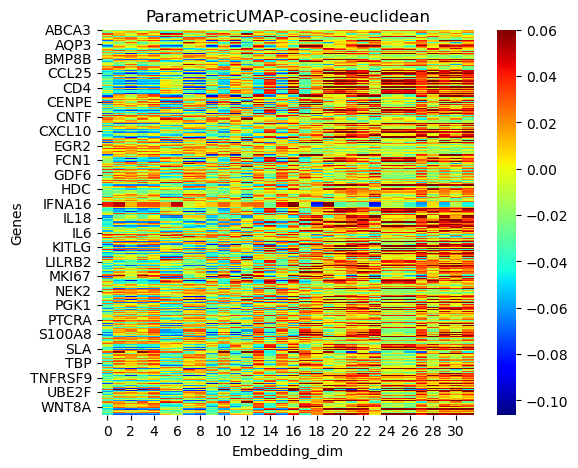

In [33]:
X = x_emb.cpu().numpy()
dfx = pd.DataFrame(X, index = dfpe.index)

fig, ax = plt.subplots(figsize=(6,5))
sns.heatmap(dfx, cmap = 'jet', ax=ax, vmax=0.06)

ax.set_ylabel('Genes')
ax.set_xlabel('Embedding_dim')
ax.set_title('ParametricUMAP-%s-%s' % (metric, output_metric))